In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression


from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [283]:
data = pd.read_csv('weight-height.csv')
data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [287]:
# Проверим, есть ли пропущенные значения
print(data.isna().sum())

Gender    0
Height    0
Weight    0
dtype: int64


In [29]:
data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [238]:
# Переведем дюймы в см, футы в кг
data['Height'] *= 2.54
data['Weight'] *= 0.45


In [239]:
data.head()

,Gender,Height,Weight
0,Male,187.571423,108.852103
1,Male,174.706036,73.039713
2,Male,188.239668,95.733385
3,Male,182.196685,99.019112
4,Male,177.499761,92.857410


In [288]:
data['Gender'].value_counts(normalize=True)


Male      0.5
Female    0.5
Name: Gender, dtype: float64

In [241]:
data_male = data[data['Gender'] == 'Male'].copy()
data_female = data[data['Gender'] == 'Female'].copy()

data_male.head()
data_female.head()

,Gender,Height,Weight
5000,Female,149.633259,45.939747
5001,Female,165.684232,63.587620
5002,Female,160.957270,58.968631
5003,Female,163.779193,57.677180
5004,Female,156.954464,58.401633


In [242]:
data_male.describe()

,Height,Weight
count,5000.000000,5000.000000
mean,175.326919,84.159279
std,7.272940,8.901520
min,148.353539,50.806323
25%,170.623685,78.249495
50%,175.330380,84.165096
75%,180.311409,90.161011
max,200.656806,121.495364


In [243]:
data_female.describe()

,Height,Weight
count,5000.000000,5000.000000
mean,161.820285,61.137042
std,6.848561,8.560111
min,137.828359,29.115057
25%,157.211881,55.320343
50%,161.876547,61.252912
75%,166.531456,66.964917
max,186.409548,91.006746


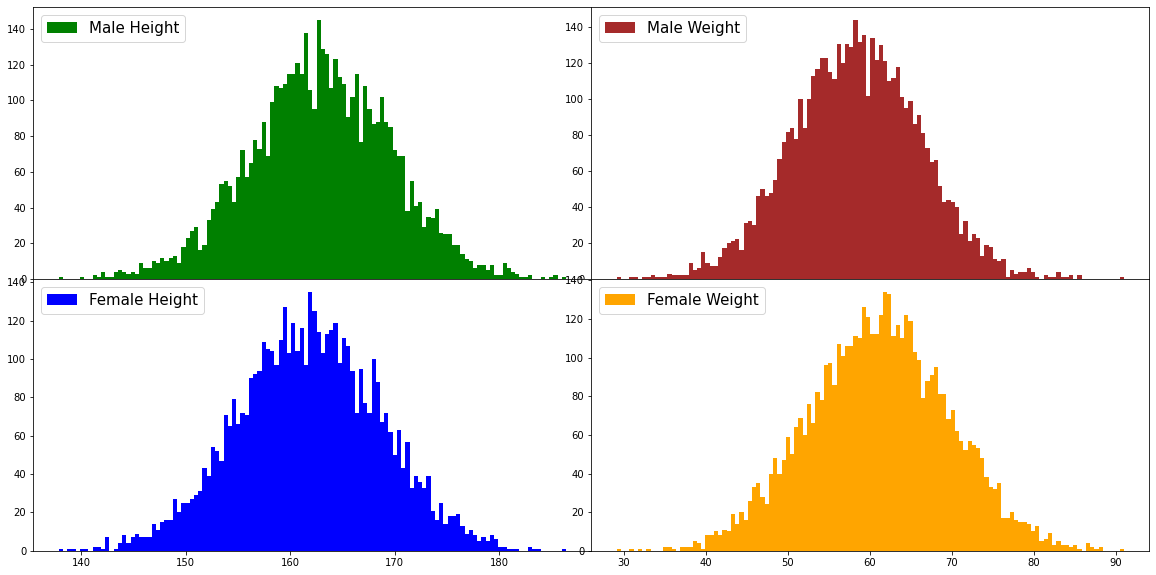

In [244]:
# Из гистограмм и описательных статистик видим, что критичных выбросов нет,
# распределение похоже на нормальное 
fig, axes = plt.subplots(2,2, figsize=(20,10))
plt.subplots_adjust(wspace=0, hspace=0)

axes[0,0].hist(data_male['Height'],
              label='Male Height',
              bins=120,
              color='green')

axes[0,1].hist(data_male['Weight'], 
               label='Male Weight', 
               bins=120, 
               color='brown') 
               

axes[1,0].hist(data_female['Height'], 
               label='Female Height', 
               bins=120, 
               color='blue')

axes[1,1].hist(data_female['Weight'], 
               label='Female Weight', 
               bins=120, 
               color='orange')

axes[0,0].legend(loc=2, 
                 fontsize=15)

axes[0,1].legend(loc=2, 
                 fontsize=15)

axes[1,0].legend(loc=2, 
                 fontsize=15)

axes[1,1].legend(loc=2, 
                 fontsize=15)

plt.savefig('plt_histogram.png')



In [245]:
mean = data_male['Height'].mean()
print('Средний рост у мужчин:\t{:.2f}'.format(mean))

Средний рост у мужчин:	175.33


In [246]:
data_male['Height_d'] = (data_male['Height'] - mean) ** 2
data_male['Height_d'].head(10)

0    149.927893
1      0.385495
2    166.739089
3     47.193692
4      4.721246
5     20.288347
6      0.375539
7      2.964214
8     25.997623
9    200.149603
Name: Height_d, dtype: float64

In [247]:
disp = data_male['Height_d'].mean()
print('Дисперсия роста у мужчин:\t{:.2f}'.format(disp))

Дисперсия роста у мужчин:	52.89


In [248]:
std = disp ** 0.5
print('std:\t{:.2f}'.format(std))

std:	7.27


In [249]:
def getStats(series, title='noname'):
    print('{}\n'.format(title.upper()))
    descr = series.describe()
    
    mean = descr['mean']
    print('Mean:\t{:.0f}'.format(mean))
    
    std = descr['std']
    print('Std:\t{:.0f}'.format(std))
    
    # 68%
    devi_1 = [mean - std, mean + std]
    # 95%
    devi_2 = [mean - 2 * std, mean + 2 * std]
    # 99.7%
    devi_3 = [mean - 3 * std, mean + 3 * std]
    
    print('68% is from\t{:.0f} to {:.0f}'.format(devi_1[0], devi_1[1]))
    print('95% is from\t{:.0f} to {:.0f}'.format(devi_2[0], devi_2[1]))
    print('99.7% is from\t{:.0f} to {:.0f}'.format(devi_3[0], devi_3[1]))
    

In [250]:
# Доверительные интервалы для роста мужчин
getStats(data_male['Height'], title='Male Height')

MALE HEIGHT

Mean:	175
Std:	7
68% is from	168 to 183
95% is from	161 to 190
99.7% is from	154 to 197


In [251]:
# Доверительные интервалы для веса мужчин
getStats(data_male['Weight'], title='Male Weight')

MALE WEIGHT

Mean:	84
Std:	9
68% is from	75 to 93
95% is from	66 to 102
99.7% is from	57 to 111


In [252]:
# Доверительные интервалы для роста женщин
getStats(data_female['Height'], title='Female Height')

FEMALE HEIGHT

Mean:	162
Std:	7
68% is from	155 to 169
95% is from	148 to 176
99.7% is from	141 to 182


In [253]:
# Доверительные интервалы для веса женщин
getStats(data_female['Weight'], title='Female Weight')

FEMALE WEIGHT

Mean:	61
Std:	9
68% is from	53 to 70
95% is from	44 to 78
99.7% is from	35 to 87


In [254]:
# Переведем гендер в бинарную переменную
data_encode = pd.get_dummies(data)
data_encode.sample(3)

,Height,Weight,Gender_Female,Gender_Male
387,179.195075,89.045718,0,1
1228,185.117973,90.599934,0,1
2487,185.571838,88.226626,0,1


In [255]:
# Отбросим переменную Weight
X = data_encode.drop('Weight', axis=1)
y = data_encode['Weight']
X.head()

,Height,Gender_Female,Gender_Male
0,187.571423,0,1
1,174.706036,0,1
2,188.239668,0,1
3,182.196685,0,1
4,177.499761,0,1


In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)

In [273]:
# Прогоним данные через несколько моделей

def metrics(y_true, y_pred):
    print('MAE:',mean_absolute_error(y_true, y_pred),'\n')
    print('MSE:', mean_squared_error(y_true, y_pred),'\n')
    print('RMSE:', np.sqrt(mean_squared_error(y_true, y_pred)),'\n')
    
def predictions(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    actual = [ y_train, y_test]
    pred = [train_pred, test_pred]
    data = ['Train', 'Test']
    
    for i in range(2):
        print(data[i])
        metrics(actual[i], pred[i])
    sns.scatterplot(x=y_test, y=test_pred)
    plt.show()

Train
MAE: 2.90829541032154 

MSE: 13.239486688804758 

RMSE: 3.6386105437109864 

Test
MAE: 2.907065172051744 

MSE: 13.39099309046342 

RMSE: 3.659370586653314 



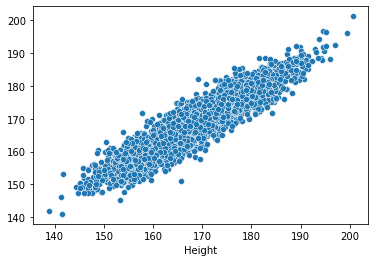

In [274]:
lr = LinearRegression()
test_pred = predictions(lr) 

Train
MAE: 2.597548248870563 

MSE: 10.609171951156613 

RMSE: 3.2571723858519697 

Test
MAE: 3.1583289006397828 

MSE: 15.787368564290286 

RMSE: 3.973332173917792 



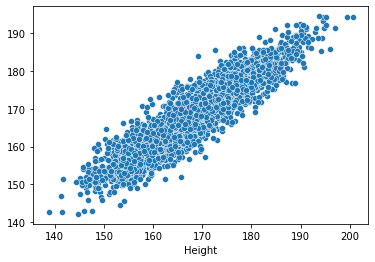

In [275]:
knn = KNeighborsRegressor()

predictions(knn)

Train
MAE: 0.0003969864611247707 

MSE: 0.0005515938761072917 

RMSE: 0.023486035768245175 

Test
MAE: 4.072592216610757 

MSE: 26.262475551318683 

RMSE: 5.124692727502663 



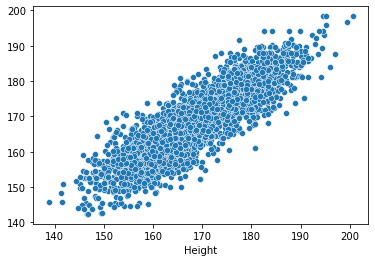

In [276]:
dtree = DecisionTreeRegressor()

predictions(dtree)

Train
MAE: 1.3035618303156256 

MSE: 2.6910709228621905 

RMSE: 1.640448390795087 

Test
MAE: 3.4673480456429764 

MSE: 18.98554442746346 

RMSE: 4.357240460137983 



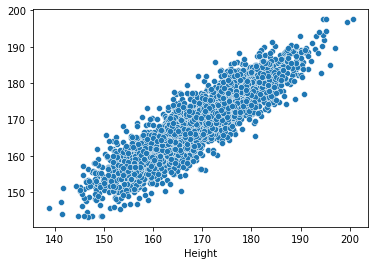

In [277]:
rf = RandomForestRegressor()

predictions(rf)

Train
MAE: 2.8292826873934307 

MSE: 12.538814808156534 

RMSE: 3.541018894069408 

Test
MAE: 2.928361828980459 

MSE: 13.544736460973912 

RMSE: 3.6803174402453265 



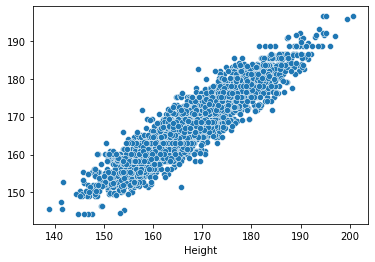

In [278]:
grad = GradientBoostingRegressor()

predictions(grad)

Train
MAE: 2.9836626808618987 

MSE: 13.818103942600663 

RMSE: 3.7172710343208313 

Test
MAE: 3.0166699988587946 

MSE: 14.418711932021232 

RMSE: 3.797197905300859 



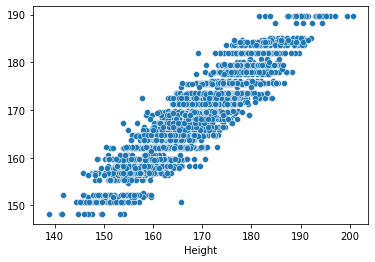

In [279]:
ada = AdaBoostRegressor()

predictions(ada)

Train
MAE: 2.4595569468091263 

MSE: 9.624712058483622 

RMSE: 3.1023720051734 

Test
MAE: 3.0153344699236375 

MSE: 14.292505824589151 

RMSE: 3.780543059480893 



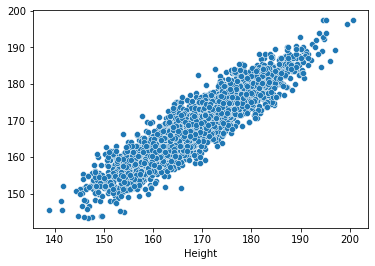

In [280]:
xgb = XGBRegressor()

predictions(xgb)

In [281]:
X_h = data_encode.drop('Height', axis=1)
y_h = data_encode['Height']

In [266]:
X_train, X_test, y_train, y_test = train_test_split(X_h, y_h, test_size = 0.3, random_state=100)


In [267]:
model_list = [lr, knn, dtree, rf, grad, ada, xgb]


--LinearRegression() --
Train
MAE: 3.586213940663889 

MSE: 20.164751910667032 

RMSE: 4.490518000260886 

Test
MAE: 3.620569768802328 

MSE: 20.62287370997411 

RMSE: 4.541241428285234 



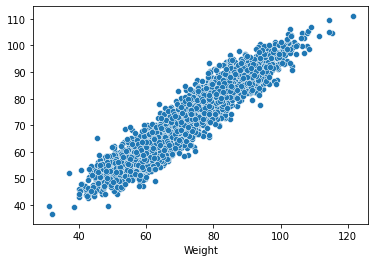

--KNeighborsRegressor() --
Train
MAE: 3.219532482272911 

MSE: 16.21192257468015 

RMSE: 4.026403180840209 

Test
MAE: 4.000960048898198 

MSE: 25.036965881762153 

RMSE: 5.003695222709128 



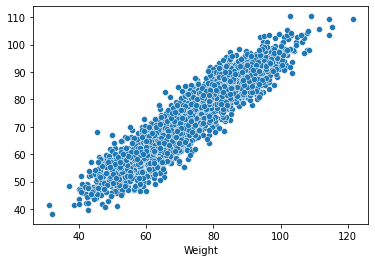

--DecisionTreeRegressor() --
Train
MAE: 0.009283390874352456 

MSE: 0.05373478212590521 

RMSE: 0.2318076403527399 

Test
MAE: 5.123029954314769 

MSE: 41.559299701239524 

RMSE: 6.446650269809859 



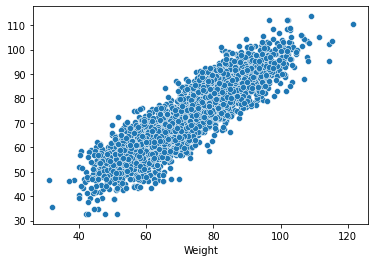

--RandomForestRegressor() --
Train
MAE: 1.6070646428470587 

MSE: 4.151044825406751 

RMSE: 2.037411304917775 

Test
MAE: 4.402665796257391 

MSE: 30.454151815954745 

RMSE: 5.518528047944918 



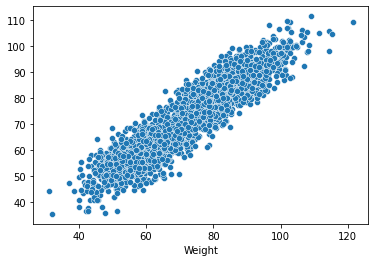

--GradientBoostingRegressor() --
Train
MAE: 3.4910256241326563 

MSE: 19.182586390306234 

RMSE: 4.379792962036703 

Test
MAE: 3.6637440108612025 

MSE: 21.06799680951029 

RMSE: 4.58998875919215 



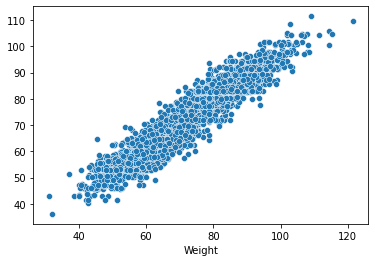

--AdaBoostRegressor() --
Train
MAE: 3.6913319400021853 

MSE: 21.303754431940465 

RMSE: 4.615599032838583 

Test
MAE: 3.8081334699985443 

MSE: 22.92079560521872 

RMSE: 4.787566772925336 



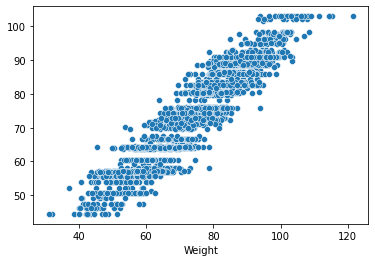

--XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) --
Train
MAE: 3.0269008718662134 

MSE: 14.774832158798027 

RMSE: 3.8438043861255515 

Test
MAE: 3.8220172007769686 

MSE: 22.837782681257274 

RMSE: 4.778889272755467 



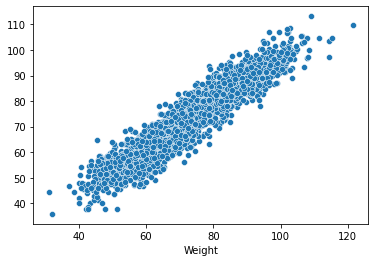

In [268]:
for model in model_list:
    print(f'--{model} --')
    predictions(model)